In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch as t
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from einops import rearrange
from einops.layers.torch import Rearrange

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from typing import Callable
from tqdm.notebook import tqdm_notebook

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
# testset = datasets.MNIST(root="./data", train=False, transform=transform)
# testloader = DataLoader(testset, batch_size=64)

In [4]:
device = 'cuda:0' if t.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
def show_images(model, data_to_plot):

    device = next(model.parameters()).device
    data_to_plot = data_to_plot.to(device)
    output = model(data_to_plot)
    if isinstance(output, tuple):
        output = output[0]

    both = t.concat((data_to_plot.squeeze(), output.squeeze()), dim=0).cpu().detach().numpy()
    both = np.clip((both * 0.3081) + 0.1307, 0, 1)

    # fig = px.imshow(both, facet_col=0, facet_col_wrap=10, color_continuous_scale="greys_r")
    # fig.update_layout(coloraxis_showscale=False).update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
    # for i in range(10):
    #     fig.layout.annotations[i]["text"] = ""
    #     fig.layout.annotations[i+10]["text"] = str(i)
    # fig.show()
    plt.figure(figsize=(10,10))
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.xticks(list(range(14, 14+28*n_points, 28)), [f"{i:.2f}" for i in x])
    plt.yticks(list(range(14, 14+28*n_points, 28)), [f"{i:.2f}" for i in x])
    plt.imshow(output_single_image, cmap="gray");

data_to_plot = dict()
for data, target in DataLoader(trainset, batch_size=1):
    if target.item() not in data_to_plot:
        data_to_plot[target.item()] = data.squeeze()
        if len(data_to_plot) == 10:
            break
data_to_plot = t.stack([data_to_plot[i] for i in range(10)]).to(t.float).unsqueeze(1)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dims=5):
        super().__init__()
        self.latent_dims = latent_dims
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            Rearrange('b (c h w) -> b c h w', c=32, h=7, w=7),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        device = x.device

        mu, logsigma = self.encoder(x).split(self.latent_dims, -1)
        sigma = t.exp(logsigma)
        epsilon = t.randn_like(sigma).to(device)

        z = mu + sigma * epsilon
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logsigma

In [7]:
def train_vae(
    model,
    optimizer,
    trainloader: DataLoader,
    epochs: int,
    beta: float = 1.0,
    device: str = device,
) -> list:
    '''
    Defines a ConvNet using our previous code, and trains it on the data in trainloader.
    '''
    model.train()
    rec_loss_list = []
    kl_loss_list = []

    for epoch in tqdm_notebook(range(epochs)):
        inner_bar = tqdm_notebook(trainloader, leave=False)
        for x, _ in inner_bar:
            # Get batch
            x = x.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Generate output
            x_prime, mu, logsigma = model(x)

            # Calculate loss
            rec_loss = nn.functional.mse_loss(x, x_prime)
            KL_loss = (-logsigma + 0.5 * (t.exp(logsigma*2) + mu ** 2) - 0.5).mean() * beta
            loss = rec_loss + KL_loss

            # Backprop and step
            loss.backward()
            optimizer.step()

            # Metrics
            rec_loss_list.append(rec_loss.item())
            kl_loss_list.append(KL_loss.item())
            desc_str = f'rl={rec_loss.item() :.4f}, kl={KL_loss.item() :.4f}, loss={loss.item() :.4f}'
            inner_bar.set_description(desc_str)

    return rec_loss_list, kl_loss_list

In [8]:
model = VAE().to(device).train()
opt = t.optim.Adam(model.parameters(), weight_decay=1e-5)

In [9]:
rec_loss_list, kl_loss_list = train_vae(model, opt, trainloader, 5, beta=0.1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [10]:
with t.inference_mode():
    show_images(model, data_to_plot)

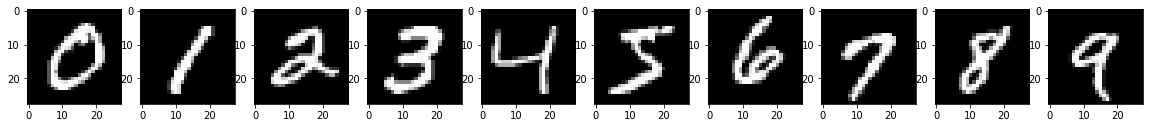

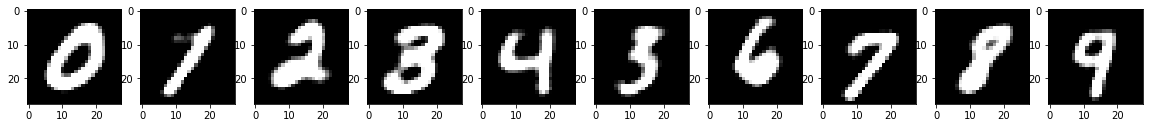

In [38]:
# Get samples of each digit eg. imgs[0] has tensor for digit 0
imgs = []
for i in range(10):
    loc_i = (trainset.targets == i).nonzero()[0][0].item()
    img = trainset[loc_i][0]
    imgs.append(img)

# Plot original images
fig = plt.figure(figsize=(20, 10))

for i in range(10):
    fig.add_subplot(1, 10, i+1)
    img = imgs[i] * 0.3081 + 0.1307
    plt.imshow(transforms.ToPILImage()(img), cmap='gray')

# Plot reconstructed images
fig = plt.figure(figsize=(20, 10))
model.eval()

for i in range(10):
    fig.add_subplot(1, 10, i+1)  
    with t.inference_mode():
        rec = model(imgs[i].view(1, 1, 28, 28).to(device))[0].view(1, 28, 28)
    rec * 0.3081 + 0.1307
    plt.imshow(transforms.ToPILImage()(rec.clip(0, 1)), cmap='gray')

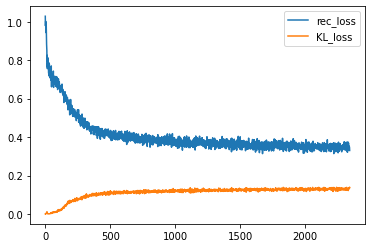

In [11]:
df = pd.DataFrame()
df['rec_loss'] = rec_loss_list
df['KL_loss'] = kl_loss_list
df.plot()

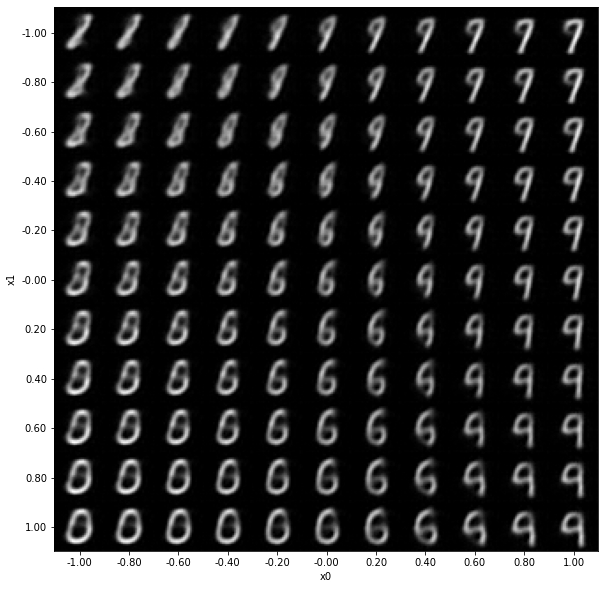

In [25]:
n_points = 11
latent_dim_size = 5

# Constructing latent dim data by making two of the dimensions vary independently between 0 and 1
latent_dim_data = t.zeros((n_points, n_points, latent_dim_size), device=device)
x = t.linspace(-1, 1, n_points)
latent_dim_data[:, :, 4] = x.unsqueeze(0)
latent_dim_data[:, :, 3] = x.unsqueeze(1)
# Rearranging so we have a single batch dimension
latent_dim_data = rearrange(latent_dim_data, "b1 b2 latent_dim -> (b1 b2) latent_dim")

# Getting model output, and normalising & truncating it in the range [0, 1]
output = model.decoder(latent_dim_data).detach().cpu().numpy()
output_truncated = np.clip((output * 0.3081) + 0.1307, 0, 1)
output_single_image = rearrange(output_truncated, "(b1 b2) 1 height width -> (b1 height) (b2 width)", b1=n_points)

# Plotting results
plt.figure(figsize=(10,10))
plt.xlabel('x0')
plt.ylabel('x1')
plt.xticks(list(range(14, 14+28*n_points, 28)), [f"{i:.2f}" for i in x])
plt.yticks(list(range(14, 14+28*n_points, 28)), [f"{i:.2f}" for i in x])
plt.imshow(output_single_image, cmap="gray");